Found cached dataset parquet (C:/Users/HououinKyouma/.cache/huggingface/datasets/Maysee___parquet/Maysee--tiny-imagenet-35af7c46a941f08e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

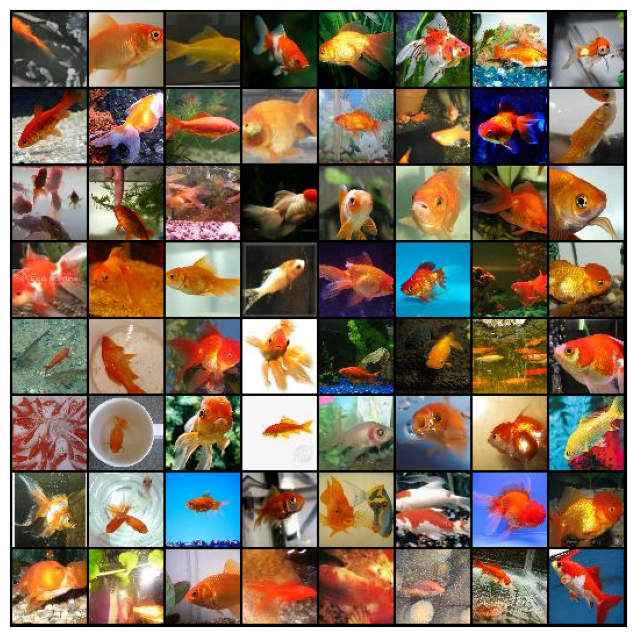

In [7]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.utils import save_image
from tqdm.notebook import tqdm
from dataset import Dataset
from configuration import config

batch_size = config.dataloader.batch_size
ds = Dataset.load(**config.dataset)
dataloader = ds.dataloader(**config.dataloader, type='train')

def denormalize(images):
  return images * 0.5 + 0.5

def show_images(images):
  figure, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([])
  ax.set_yticks([])

  ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))

def show_batch(dataloader):
  for (images, _) in dataloader:
    images = images.detach()[:64]

    show_images(denormalize(images))
    break

show_batch(dataloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


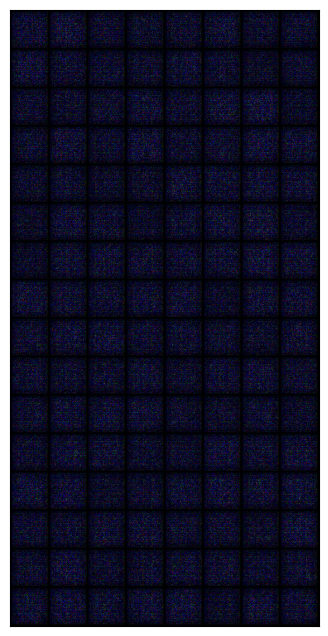

In [8]:
from discriminator import Discriminator
from generator import Generator
from weights import initialize_weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
discriminator = Discriminator(use_gpu=config.use_gpu, scale=64).apply(initialize_weights).to(device)
generator = Generator(use_gpu=config.use_gpu, scale=64).apply(initialize_weights).to(device)

latent_size = 128
noises = torch.randn(batch_size, latent_size, 1, 1).to(device)
noise_images = generator(noises)

show_images(noise_images.cpu())

In [9]:
from torch.nn import BCELoss
def save_samples(index, noises, show=True):
  images = generator(noises)

  filename = f'output-images-{index:0=4d}.png'
  save_image(denormalize(images), os.path.join(output_directory, filename), nrow=8)
  print(f'Saving {filename}')

  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images.cpu().detach(), nrow=8).permute(1, 2, 0))

criterion = BCELoss()

def train_discriminator(images, optimizer):
  optimizer.zero_grad()

  images_predictions = discriminator(images)
  images_targets = torch.ones(images.size(0), 1, device=device)
  images_targets = images_targets * 0.9

  images_loss = criterion(images_predictions, images_targets)
  images_score = torch.mean(images_predictions).item()

  noises = torch.randn(batch_size, latent_size, 1, 1, device=device)
  noises_images = generator(noises)

  noises_targets = torch.zeros(noises_images.size(0), 1, device=device)
  noises_targets = noises_targets + 0.1

  noises_predictions = discriminator(noises_images)
  noises_loss = criterion(noises_predictions, noises_targets)
  noises_score = torch.mean(noises_predictions).item()

  loss = images_loss + noises_loss
  loss.backward()
  optimizer.step()

  return loss.item(), images_score, noises_score

def train_generator(optimizer):
  optimizer.zero_grad()

  noises = torch.randn(batch_size, latent_size, 1, 1, device=device)
  noises_images = generator(noises)

  predictions = discriminator(noises_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = criterion(predictions, targets)

  loss.backward()
  optimizer.step()

  return loss.item()

def fit(discriminator, generator, dataloader, epochs, learning_rate):
  torch.cuda.empty_cache()

  losses_generator = []
  losses_discriminator = []
  images_scores = []
  noises_scores = []
  fid_scores = []

  optimizer_discriminator = torch.optim.AdamW(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
  optimizer_generator = torch.optim.AdamW(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for images, _ in tqdm(dataloader):
      images = images.to(device)

      loss_discriminator, images_score, noises_score = train_discriminator(images, optimizer_discriminator)
      loss_generator = train_generator(optimizer_generator)

    losses_generator.append(loss_generator)
    losses_discriminator.append(loss_discriminator)

    images_fid = images[:8].type(torch.uint8).cpu()
    noises_fid = generator(noises[:8]).type(torch.uint8).cpu()
    fid = FrechetInceptionDistance(feature=2048)
    fid.update(images_fid, real=True)
    fid.update(noises_fid, real=False)
    fid_score = fid.compute()

    fid_scores.append(fid_score)
    images_scores.append(images_score)
    noises_scores.append(noises_score)

    print(
      f"Epoch [{epoch + 1}/{epochs}]"
      f" loss_generator: {loss_generator:.4f}"
      f" loss_discriminator: {loss_discriminator:.4f}"
      f" images_score: {images_score:.4f}"
      f" noises_score: {noises_score:.4f}"
      f" fid_score: {fid_score:.4f}"
    )

    save_samples(epoch, constant_noise, show=False)

  return losses_generator, losses_discriminator, images_scores, noises_scores, fid_scores


In [10]:
from torch.nn.functional import adaptive_avg_pool2d
from numpy.linalg import linalg
import numpy as np
from torchmetrics.image.fid import FrechetInceptionDistance


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving output-images-0000.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/200] loss_generator: 1.3310 loss_discriminator: 1.2846 images_score: 0.5756 noises_score: 0.4609 fid_score: 245.2745
Saving output-images-0000.png


C:\Users\HououinKyouma\PycharmProjects\2023-wk\venv\lib\site-packages\scipy\linalg\_matfuncs_sqrtm.py:205: RuntimeWarning: invalid value encountered in double_scalars
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/200] loss_generator: 1.6424 loss_discriminator: 1.0140 images_score: 0.6966 noises_score: 0.3609 fid_score: 312.6102
Saving output-images-0001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/200] loss_generator: 1.8308 loss_discriminator: 0.9857 images_score: 0.7051 noises_score: 0.3285 fid_score: 316.1920
Saving output-images-0002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/200] loss_generator: 2.1697 loss_discriminator: 0.9047 images_score: 0.7364 noises_score: 0.2969 fid_score: 261.5625
Saving output-images-0003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/200] loss_generator: 2.2800 loss_discriminator: 0.8916 images_score: 0.7554 noises_score: 0.3020 fid_score: 206.5355
Saving output-images-0004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/200] loss_generator: 2.4546 loss_discriminator: 0.8867 images_score: 0.7248 noises_score: 0.2555 fid_score: 374.0808
Saving output-images-0005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/200] loss_generator: 2.5946 loss_discriminator: 0.8101 images_score: 0.7762 noises_score: 0.2142 fid_score: 386.4906
Saving output-images-0006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/200] loss_generator: 2.7069 loss_discriminator: 0.7859 images_score: 0.7984 noises_score: 0.2225 fid_score: 345.3681
Saving output-images-0007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/200] loss_generator: 2.7748 loss_discriminator: 0.7802 images_score: 0.7799 noises_score: 0.1853 fid_score: 323.4765
Saving output-images-0008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/200] loss_generator: 3.1702 loss_discriminator: 0.7792 images_score: 0.8138 noises_score: 0.2331 fid_score: 399.1074
Saving output-images-0009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/200] loss_generator: 3.1104 loss_discriminator: 0.7818 images_score: 0.7464 noises_score: 0.1610 fid_score: 237.1147
Saving output-images-0010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/200] loss_generator: 3.3386 loss_discriminator: 0.7514 images_score: 0.8202 noises_score: 0.1941 fid_score: 245.7986
Saving output-images-0011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/200] loss_generator: 3.4602 loss_discriminator: 0.7084 images_score: 0.8625 noises_score: 0.1680 fid_score: 255.2837
Saving output-images-0012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/200] loss_generator: 3.1190 loss_discriminator: 0.6953 images_score: 0.8526 noises_score: 0.1393 fid_score: 311.7738
Saving output-images-0013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/200] loss_generator: 3.2050 loss_discriminator: 0.6986 images_score: 0.8457 noises_score: 0.1396 fid_score: 307.2901
Saving output-images-0014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/200] loss_generator: 3.5464 loss_discriminator: 0.6990 images_score: 0.8763 noises_score: 0.1660 fid_score: 400.9161
Saving output-images-0015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/200] loss_generator: 3.6092 loss_discriminator: 0.7019 images_score: 0.8458 noises_score: 0.1571 fid_score: 237.0979
Saving output-images-0016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/200] loss_generator: 4.1545 loss_discriminator: 0.6987 images_score: 0.8560 noises_score: 0.1653 fid_score: 385.7879
Saving output-images-0017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/200] loss_generator: 5.2463 loss_discriminator: 0.7611 images_score: 0.8853 noises_score: 0.2694 fid_score: 348.7776
Saving output-images-0018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/200] loss_generator: 3.1365 loss_discriminator: 0.6940 images_score: 0.8401 noises_score: 0.0680 fid_score: 307.9506
Saving output-images-0019.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/200] loss_generator: 3.8550 loss_discriminator: 0.7043 images_score: 0.9003 noises_score: 0.1959 fid_score: 335.6742
Saving output-images-0020.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/200] loss_generator: 2.7447 loss_discriminator: 0.7233 images_score: 0.7808 noises_score: 0.1160 fid_score: 346.5399
Saving output-images-0021.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/200] loss_generator: 3.2962 loss_discriminator: 0.6903 images_score: 0.8479 noises_score: 0.1483 fid_score: 250.5899
Saving output-images-0022.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/200] loss_generator: 3.6668 loss_discriminator: 0.6753 images_score: 0.9115 noises_score: 0.1505 fid_score: 334.9519
Saving output-images-0023.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/200] loss_generator: 3.8873 loss_discriminator: 0.6939 images_score: 0.8900 noises_score: 0.1808 fid_score: 337.5754
Saving output-images-0024.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [26/200] loss_generator: 3.6255 loss_discriminator: 0.6961 images_score: 0.8804 noises_score: 0.1873 fid_score: 393.0063
Saving output-images-0025.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [27/200] loss_generator: 3.6991 loss_discriminator: 0.6891 images_score: 0.8774 noises_score: 0.1710 fid_score: 324.9375
Saving output-images-0026.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [28/200] loss_generator: 4.2852 loss_discriminator: 0.7142 images_score: 0.8781 noises_score: 0.2113 fid_score: 246.8869
Saving output-images-0027.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [29/200] loss_generator: 2.4336 loss_discriminator: 0.6717 images_score: 0.8698 noises_score: 0.1156 fid_score: 256.7051
Saving output-images-0028.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [30/200] loss_generator: 5.3637 loss_discriminator: 0.8668 images_score: 0.8758 noises_score: 0.3726 fid_score: 302.2399
Saving output-images-0029.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [31/200] loss_generator: 3.5567 loss_discriminator: 0.6790 images_score: 0.8949 noises_score: 0.1531 fid_score: 316.8488
Saving output-images-0030.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [32/200] loss_generator: 3.1537 loss_discriminator: 0.6733 images_score: 0.9082 noises_score: 0.0850 fid_score: 428.6827
Saving output-images-0031.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [33/200] loss_generator: 4.1690 loss_discriminator: 0.6981 images_score: 0.8819 noises_score: 0.1931 fid_score: 331.7266
Saving output-images-0032.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [34/200] loss_generator: 3.1770 loss_discriminator: 0.6919 images_score: 0.8508 noises_score: 0.1559 fid_score: 198.1949
Saving output-images-0033.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [35/200] loss_generator: 3.1459 loss_discriminator: 0.6658 images_score: 0.8863 noises_score: 0.1186 fid_score: 351.7333
Saving output-images-0034.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [36/200] loss_generator: 4.4367 loss_discriminator: 0.7219 images_score: 0.8539 noises_score: 0.2162 fid_score: 342.2590
Saving output-images-0035.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [37/200] loss_generator: 3.3037 loss_discriminator: 0.6746 images_score: 0.9060 noises_score: 0.1521 fid_score: 323.0306
Saving output-images-0036.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [38/200] loss_generator: 3.0911 loss_discriminator: 0.6675 images_score: 0.8775 noises_score: 0.1279 fid_score: 271.0053
Saving output-images-0037.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [39/200] loss_generator: 3.8063 loss_discriminator: 0.6868 images_score: 0.8912 noises_score: 0.1788 fid_score: 416.0999
Saving output-images-0038.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [40/200] loss_generator: 2.6722 loss_discriminator: 0.6712 images_score: 0.8810 noises_score: 0.1406 fid_score: 272.2229
Saving output-images-0039.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [41/200] loss_generator: 2.8749 loss_discriminator: 0.6643 images_score: 0.8973 noises_score: 0.0773 fid_score: 363.4411
Saving output-images-0040.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [42/200] loss_generator: 2.9076 loss_discriminator: 0.6629 images_score: 0.8939 noises_score: 0.0856 fid_score: 282.6707
Saving output-images-0041.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [43/200] loss_generator: 2.5626 loss_discriminator: 0.6657 images_score: 0.8752 noises_score: 0.0907 fid_score: 310.8387
Saving output-images-0042.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [44/200] loss_generator: 2.9739 loss_discriminator: 0.6685 images_score: 0.8654 noises_score: 0.1092 fid_score: 305.5422
Saving output-images-0043.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [45/200] loss_generator: 2.8217 loss_discriminator: 0.6855 images_score: 0.8442 noises_score: 0.0784 fid_score: 404.6031
Saving output-images-0044.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [46/200] loss_generator: 3.9745 loss_discriminator: 0.6881 images_score: 0.8671 noises_score: 0.1613 fid_score: 273.5415
Saving output-images-0045.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [47/200] loss_generator: 2.3943 loss_discriminator: 0.6735 images_score: 0.8847 noises_score: 0.1157 fid_score: 294.2889
Saving output-images-0046.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [48/200] loss_generator: 2.9249 loss_discriminator: 0.6920 images_score: 0.8951 noises_score: 0.1824 fid_score: 365.8042
Saving output-images-0047.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [49/200] loss_generator: 4.5215 loss_discriminator: 0.7364 images_score: 0.8803 noises_score: 0.2458 fid_score: 291.4860
Saving output-images-0048.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [50/200] loss_generator: 2.1746 loss_discriminator: 0.6765 images_score: 0.8553 noises_score: 0.0938 fid_score: 290.1764
Saving output-images-0049.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [51/200] loss_generator: 3.6882 loss_discriminator: 0.7762 images_score: 0.9175 noises_score: 0.2874 fid_score: 318.4588
Saving output-images-0050.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [52/200] loss_generator: 3.0741 loss_discriminator: 0.6845 images_score: 0.8708 noises_score: 0.0795 fid_score: 255.8667
Saving output-images-0051.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [53/200] loss_generator: 2.5006 loss_discriminator: 0.6664 images_score: 0.8758 noises_score: 0.1000 fid_score: 295.3685
Saving output-images-0052.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [54/200] loss_generator: 4.0849 loss_discriminator: 0.7158 images_score: 0.8849 noises_score: 0.2180 fid_score: 208.7869
Saving output-images-0053.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [55/200] loss_generator: 2.7234 loss_discriminator: 0.7004 images_score: 0.9011 noises_score: 0.1632 fid_score: 286.5844
Saving output-images-0054.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [56/200] loss_generator: 3.0386 loss_discriminator: 0.7456 images_score: 0.8637 noises_score: 0.2324 fid_score: 175.6741
Saving output-images-0055.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [57/200] loss_generator: 1.5404 loss_discriminator: 0.7630 images_score: 0.7436 noises_score: 0.0889 fid_score: 322.3582
Saving output-images-0056.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [58/200] loss_generator: 2.7224 loss_discriminator: 0.8353 images_score: 0.9313 noises_score: 0.3234 fid_score: 337.9039
Saving output-images-0057.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [59/200] loss_generator: 2.3973 loss_discriminator: 0.7202 images_score: 0.8798 noises_score: 0.1921 fid_score: 384.4516
Saving output-images-0058.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [60/200] loss_generator: 2.4801 loss_discriminator: 0.6994 images_score: 0.8836 noises_score: 0.1765 fid_score: 410.8255
Saving output-images-0059.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [61/200] loss_generator: 2.4360 loss_discriminator: 0.6902 images_score: 0.8522 noises_score: 0.1526 fid_score: 341.3237
Saving output-images-0060.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [62/200] loss_generator: 2.2684 loss_discriminator: 0.7062 images_score: 0.8050 noises_score: 0.1370 fid_score: 293.1839
Saving output-images-0061.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [63/200] loss_generator: 2.7763 loss_discriminator: 0.6832 images_score: 0.8554 noises_score: 0.0975 fid_score: 300.8483
Saving output-images-0062.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [64/200] loss_generator: 2.5694 loss_discriminator: 0.6954 images_score: 0.8825 noises_score: 0.1622 fid_score: 279.6126
Saving output-images-0063.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [65/200] loss_generator: 2.9424 loss_discriminator: 0.6978 images_score: 0.8768 noises_score: 0.1710 fid_score: 239.1460
Saving output-images-0064.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [66/200] loss_generator: 2.9687 loss_discriminator: 0.6889 images_score: 0.8486 noises_score: 0.0919 fid_score: 277.0107
Saving output-images-0065.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [67/200] loss_generator: 2.6442 loss_discriminator: 0.6798 images_score: 0.8818 noises_score: 0.1411 fid_score: 297.9858
Saving output-images-0066.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [68/200] loss_generator: 2.8963 loss_discriminator: 0.6743 images_score: 0.8677 noises_score: 0.1272 fid_score: 308.4299
Saving output-images-0067.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [69/200] loss_generator: 3.4096 loss_discriminator: 0.6864 images_score: 0.8809 noises_score: 0.1731 fid_score: 258.3868
Saving output-images-0068.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [70/200] loss_generator: 3.9938 loss_discriminator: 0.7277 images_score: 0.8948 noises_score: 0.2380 fid_score: 297.6789
Saving output-images-0069.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [71/200] loss_generator: 2.3974 loss_discriminator: 0.7228 images_score: 0.7834 noises_score: 0.0752 fid_score: 346.0401
Saving output-images-0070.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [72/200] loss_generator: 4.0007 loss_discriminator: 0.7622 images_score: 0.9237 noises_score: 0.2692 fid_score: 164.3001
Saving output-images-0071.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [73/200] loss_generator: 2.6748 loss_discriminator: 0.7106 images_score: 0.7998 noises_score: 0.0954 fid_score: 260.0766
Saving output-images-0072.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [74/200] loss_generator: 2.8078 loss_discriminator: 0.6754 images_score: 0.8647 noises_score: 0.1224 fid_score: 362.0775
Saving output-images-0073.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [75/200] loss_generator: 2.8805 loss_discriminator: 0.6726 images_score: 0.8821 noises_score: 0.1388 fid_score: 254.6795
Saving output-images-0074.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [76/200] loss_generator: 2.7534 loss_discriminator: 0.6952 images_score: 0.8769 noises_score: 0.1701 fid_score: 307.8602
Saving output-images-0075.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [77/200] loss_generator: 2.8949 loss_discriminator: 0.7004 images_score: 0.8738 noises_score: 0.1177 fid_score: 328.7733
Saving output-images-0076.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [78/200] loss_generator: 2.7532 loss_discriminator: 0.6855 images_score: 0.8376 noises_score: 0.1331 fid_score: 395.9930
Saving output-images-0077.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [79/200] loss_generator: 2.8870 loss_discriminator: 0.7681 images_score: 0.7995 noises_score: 0.0318 fid_score: 324.0129
Saving output-images-0078.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [80/200] loss_generator: 2.1326 loss_discriminator: 0.6728 images_score: 0.8740 noises_score: 0.1016 fid_score: 387.4497
Saving output-images-0079.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [81/200] loss_generator: 2.7546 loss_discriminator: 0.6918 images_score: 0.8994 noises_score: 0.1610 fid_score: 294.2066
Saving output-images-0080.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [82/200] loss_generator: 2.8173 loss_discriminator: 0.6757 images_score: 0.8745 noises_score: 0.1340 fid_score: 359.9096
Saving output-images-0081.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [83/200] loss_generator: 3.5681 loss_discriminator: 0.6823 images_score: 0.9076 noises_score: 0.1585 fid_score: 339.7289
Saving output-images-0082.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [84/200] loss_generator: 2.0488 loss_discriminator: 0.6676 images_score: 0.8878 noises_score: 0.0932 fid_score: 260.7114
Saving output-images-0083.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [85/200] loss_generator: 2.8900 loss_discriminator: 0.6927 images_score: 0.9217 noises_score: 0.1790 fid_score: 414.6567
Saving output-images-0084.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [86/200] loss_generator: 2.7822 loss_discriminator: 0.6720 images_score: 0.8680 noises_score: 0.1370 fid_score: 280.4899
Saving output-images-0085.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [87/200] loss_generator: 3.5022 loss_discriminator: 0.6771 images_score: 0.9304 noises_score: 0.1389 fid_score: 290.4671
Saving output-images-0086.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [88/200] loss_generator: 5.3001 loss_discriminator: 0.7600 images_score: 0.9302 noises_score: 0.2627 fid_score: 236.1832
Saving output-images-0087.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [89/200] loss_generator: 5.4182 loss_discriminator: 0.9028 images_score: 0.8262 noises_score: 0.0124 fid_score: 360.6797
Saving output-images-0088.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [90/200] loss_generator: 2.6837 loss_discriminator: 0.7010 images_score: 0.8401 noises_score: 0.1151 fid_score: 352.4772
Saving output-images-0089.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [91/200] loss_generator: 2.6636 loss_discriminator: 0.6703 images_score: 0.8849 noises_score: 0.1353 fid_score: 382.6081
Saving output-images-0090.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [92/200] loss_generator: 2.3575 loss_discriminator: 0.6682 images_score: 0.8871 noises_score: 0.0932 fid_score: 345.6644
Saving output-images-0091.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [93/200] loss_generator: 1.9565 loss_discriminator: 1.1504 images_score: 0.5475 noises_score: 0.0095 fid_score: 334.3879
Saving output-images-0092.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [94/200] loss_generator: 2.7913 loss_discriminator: 0.7053 images_score: 0.9186 noises_score: 0.1809 fid_score: 367.7265
Saving output-images-0093.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [95/200] loss_generator: 2.6237 loss_discriminator: 0.6797 images_score: 0.8819 noises_score: 0.1328 fid_score: 362.0211
Saving output-images-0094.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [96/200] loss_generator: 2.7253 loss_discriminator: 0.6753 images_score: 0.8607 noises_score: 0.0865 fid_score: 338.3577
Saving output-images-0095.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [97/200] loss_generator: 2.4157 loss_discriminator: 0.6777 images_score: 0.8879 noises_score: 0.1467 fid_score: 337.0756
Saving output-images-0096.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [98/200] loss_generator: 2.8961 loss_discriminator: 0.6772 images_score: 0.8820 noises_score: 0.1509 fid_score: 300.4236
Saving output-images-0097.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [99/200] loss_generator: 2.8075 loss_discriminator: 0.7069 images_score: 0.9147 noises_score: 0.2080 fid_score: 277.3146
Saving output-images-0098.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [100/200] loss_generator: 3.4230 loss_discriminator: 0.6962 images_score: 0.9084 noises_score: 0.1885 fid_score: 324.3997
Saving output-images-0099.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [101/200] loss_generator: 1.3339 loss_discriminator: 0.7115 images_score: 0.8884 noises_score: 0.1858 fid_score: 325.0907
Saving output-images-0100.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [102/200] loss_generator: 2.4811 loss_discriminator: 0.7187 images_score: 0.8715 noises_score: 0.1789 fid_score: 309.1915
Saving output-images-0101.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [103/200] loss_generator: 2.4434 loss_discriminator: 0.6778 images_score: 0.9055 noises_score: 0.1502 fid_score: 464.9836
Saving output-images-0102.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [104/200] loss_generator: 2.8099 loss_discriminator: 0.6849 images_score: 0.8887 noises_score: 0.1685 fid_score: 306.9814
Saving output-images-0103.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [105/200] loss_generator: 1.8736 loss_discriminator: 0.7060 images_score: 0.7949 noises_score: 0.1135 fid_score: 340.2516
Saving output-images-0104.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [106/200] loss_generator: 3.8861 loss_discriminator: 0.9209 images_score: 0.9529 noises_score: 0.3818 fid_score: 244.7142
Saving output-images-0105.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [107/200] loss_generator: 2.6300 loss_discriminator: 0.7137 images_score: 0.8989 noises_score: 0.1932 fid_score: 361.0045
Saving output-images-0106.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [108/200] loss_generator: 2.3650 loss_discriminator: 0.7125 images_score: 0.8223 noises_score: 0.1596 fid_score: 264.2427
Saving output-images-0107.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [109/200] loss_generator: 2.4544 loss_discriminator: 0.7094 images_score: 0.8661 noises_score: 0.1899 fid_score: 276.8456
Saving output-images-0108.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [110/200] loss_generator: 2.6412 loss_discriminator: 0.7031 images_score: 0.8986 noises_score: 0.1987 fid_score: 278.8692
Saving output-images-0109.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [111/200] loss_generator: 2.3111 loss_discriminator: 0.7178 images_score: 0.7764 noises_score: 0.1132 fid_score: 324.3308
Saving output-images-0110.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [112/200] loss_generator: 1.7807 loss_discriminator: 0.7409 images_score: 0.7572 noises_score: 0.0839 fid_score: 387.9035
Saving output-images-0111.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [113/200] loss_generator: 3.2117 loss_discriminator: 0.7244 images_score: 0.9346 noises_score: 0.2125 fid_score: 252.5284
Saving output-images-0112.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [114/200] loss_generator: 2.5373 loss_discriminator: 0.6819 images_score: 0.8465 noises_score: 0.1217 fid_score: 334.9372
Saving output-images-0113.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [115/200] loss_generator: 2.9274 loss_discriminator: 0.6944 images_score: 0.8726 noises_score: 0.1660 fid_score: 300.4138
Saving output-images-0114.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [116/200] loss_generator: 2.6985 loss_discriminator: 0.7112 images_score: 0.9257 noises_score: 0.1865 fid_score: 312.6507
Saving output-images-0115.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [117/200] loss_generator: 2.6068 loss_discriminator: 0.7129 images_score: 0.8070 noises_score: 0.0706 fid_score: 474.6245
Saving output-images-0116.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [118/200] loss_generator: 2.8672 loss_discriminator: 0.6777 images_score: 0.8702 noises_score: 0.1290 fid_score: 303.5418
Saving output-images-0117.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [119/200] loss_generator: 2.3775 loss_discriminator: 0.6811 images_score: 0.8592 noises_score: 0.1261 fid_score: 326.1781
Saving output-images-0118.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [120/200] loss_generator: 2.8393 loss_discriminator: 0.6925 images_score: 0.8708 noises_score: 0.1775 fid_score: 297.4955
Saving output-images-0119.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [121/200] loss_generator: 2.5868 loss_discriminator: 0.6822 images_score: 0.8553 noises_score: 0.0654 fid_score: 308.5576
Saving output-images-0120.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [122/200] loss_generator: 2.7091 loss_discriminator: 0.6848 images_score: 0.8615 noises_score: 0.1406 fid_score: 238.7530
Saving output-images-0121.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [123/200] loss_generator: 2.1125 loss_discriminator: 0.7010 images_score: 0.8172 noises_score: 0.1340 fid_score: 322.9220
Saving output-images-0122.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [124/200] loss_generator: 3.0625 loss_discriminator: 0.6941 images_score: 0.9042 noises_score: 0.1694 fid_score: 244.6038
Saving output-images-0123.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [125/200] loss_generator: 2.5299 loss_discriminator: 0.6957 images_score: 0.8358 noises_score: 0.1389 fid_score: 290.8368
Saving output-images-0124.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [126/200] loss_generator: 2.6659 loss_discriminator: 0.6960 images_score: 0.8392 noises_score: 0.1437 fid_score: 268.9802
Saving output-images-0125.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [127/200] loss_generator: 3.9900 loss_discriminator: 3.5200 images_score: 0.0530 noises_score: 0.0023 fid_score: 264.0715
Saving output-images-0126.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [128/200] loss_generator: 2.7704 loss_discriminator: 0.7549 images_score: 0.7917 noises_score: 0.1690 fid_score: 395.1292
Saving output-images-0127.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [129/200] loss_generator: 2.5116 loss_discriminator: 0.7686 images_score: 0.8215 noises_score: 0.2417 fid_score: 285.3368
Saving output-images-0128.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [130/200] loss_generator: 1.7572 loss_discriminator: 0.7362 images_score: 0.7674 noises_score: 0.1126 fid_score: 305.7324
Saving output-images-0129.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [131/200] loss_generator: 2.8976 loss_discriminator: 0.7167 images_score: 0.8195 noises_score: 0.0822 fid_score: 274.2732
Saving output-images-0130.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [132/200] loss_generator: 2.5160 loss_discriminator: 0.6964 images_score: 0.8458 noises_score: 0.1520 fid_score: 397.4628
Saving output-images-0131.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [133/200] loss_generator: 2.2035 loss_discriminator: 0.6974 images_score: 0.8337 noises_score: 0.1348 fid_score: 249.0188
Saving output-images-0132.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [134/200] loss_generator: 2.4233 loss_discriminator: 0.6916 images_score: 0.8284 noises_score: 0.1096 fid_score: 307.9217
Saving output-images-0133.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [135/200] loss_generator: 2.5254 loss_discriminator: 0.6777 images_score: 0.8671 noises_score: 0.0743 fid_score: 195.2721
Saving output-images-0134.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [136/200] loss_generator: 2.4550 loss_discriminator: 0.7182 images_score: 0.8188 noises_score: 0.1778 fid_score: 255.6956
Saving output-images-0135.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [137/200] loss_generator: 4.1216 loss_discriminator: 0.7840 images_score: 0.8995 noises_score: 0.2944 fid_score: 314.1308
Saving output-images-0136.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [138/200] loss_generator: 2.0553 loss_discriminator: 0.7258 images_score: 0.8353 noises_score: 0.1807 fid_score: 322.8743
Saving output-images-0137.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [139/200] loss_generator: 2.8354 loss_discriminator: 0.7428 images_score: 0.8773 noises_score: 0.2412 fid_score: 214.1991
Saving output-images-0138.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [140/200] loss_generator: 2.3096 loss_discriminator: 0.6959 images_score: 0.8324 noises_score: 0.1343 fid_score: 224.9975
Saving output-images-0139.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [141/200] loss_generator: 3.1634 loss_discriminator: 0.7198 images_score: 0.9164 noises_score: 0.2132 fid_score: 280.3022
Saving output-images-0140.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [142/200] loss_generator: 1.9482 loss_discriminator: 0.7885 images_score: 0.9177 noises_score: 0.2493 fid_score: 317.1415
Saving output-images-0141.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [143/200] loss_generator: 2.2787 loss_discriminator: 0.7945 images_score: 0.8311 noises_score: 0.2727 fid_score: 394.2403
Saving output-images-0142.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [144/200] loss_generator: 2.3204 loss_discriminator: 0.7110 images_score: 0.8341 noises_score: 0.1661 fid_score: 275.5947
Saving output-images-0143.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [145/200] loss_generator: 1.2765 loss_discriminator: 0.9257 images_score: 0.5965 noises_score: 0.1163 fid_score: 285.3286
Saving output-images-0144.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [146/200] loss_generator: 3.7226 loss_discriminator: 1.0374 images_score: 0.9495 noises_score: 0.4686 fid_score: 346.4014
Saving output-images-0145.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [147/200] loss_generator: 2.6941 loss_discriminator: 0.7061 images_score: 0.8267 noises_score: 0.1426 fid_score: 249.9194
Saving output-images-0146.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [148/200] loss_generator: 1.6497 loss_discriminator: 0.7303 images_score: 0.7753 noises_score: 0.1068 fid_score: 297.8341
Saving output-images-0147.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [149/200] loss_generator: 2.6082 loss_discriminator: 0.7059 images_score: 0.8104 noises_score: 0.1191 fid_score: 332.8730
Saving output-images-0148.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [150/200] loss_generator: 2.9620 loss_discriminator: 0.9028 images_score: 0.9167 noises_score: 0.3936 fid_score: 304.3055
Saving output-images-0149.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [151/200] loss_generator: 2.6928 loss_discriminator: 0.7153 images_score: 0.8497 noises_score: 0.0780 fid_score: 305.7889
Saving output-images-0150.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [152/200] loss_generator: 2.5744 loss_discriminator: 0.6974 images_score: 0.8608 noises_score: 0.1314 fid_score: 374.6202
Saving output-images-0151.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [153/200] loss_generator: 2.4952 loss_discriminator: 0.7157 images_score: 0.8193 noises_score: 0.1092 fid_score: 302.6140
Saving output-images-0152.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [154/200] loss_generator: 2.1020 loss_discriminator: 0.7189 images_score: 0.8263 noises_score: 0.0600 fid_score: 241.4159
Saving output-images-0153.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [155/200] loss_generator: 1.2859 loss_discriminator: 1.2569 images_score: 0.4692 noises_score: 0.0237 fid_score: 312.3344
Saving output-images-0154.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [156/200] loss_generator: 2.4304 loss_discriminator: 0.7893 images_score: 0.7514 noises_score: 0.0754 fid_score: 320.3264
Saving output-images-0155.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [157/200] loss_generator: 2.8001 loss_discriminator: 0.7689 images_score: 0.8412 noises_score: 0.2288 fid_score: 304.8565
Saving output-images-0156.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [158/200] loss_generator: 3.2627 loss_discriminator: 1.0139 images_score: 0.8647 noises_score: 0.4536 fid_score: 396.1861
Saving output-images-0157.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [159/200] loss_generator: 3.3101 loss_discriminator: 1.1920 images_score: 0.8907 noises_score: 0.5504 fid_score: 353.7709
Saving output-images-0158.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [160/200] loss_generator: 2.7999 loss_discriminator: 0.7646 images_score: 0.7971 noises_score: 0.1840 fid_score: 304.2947
Saving output-images-0159.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [161/200] loss_generator: 2.1830 loss_discriminator: 0.7344 images_score: 0.8024 noises_score: 0.1436 fid_score: 326.9773
Saving output-images-0160.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [162/200] loss_generator: 2.2168 loss_discriminator: 0.7384 images_score: 0.7980 noises_score: 0.1406 fid_score: 421.4150
Saving output-images-0161.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [163/200] loss_generator: 2.3166 loss_discriminator: 0.7382 images_score: 0.8008 noises_score: 0.1711 fid_score: 231.1377
Saving output-images-0162.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [164/200] loss_generator: 0.3167 loss_discriminator: 0.9875 images_score: 0.5745 noises_score: 0.1453 fid_score: 286.6795
Saving output-images-0163.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [165/200] loss_generator: 1.6331 loss_discriminator: 0.8369 images_score: 0.7394 noises_score: 0.2342 fid_score: 334.1505
Saving output-images-0164.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [166/200] loss_generator: 1.9803 loss_discriminator: 0.7859 images_score: 0.8418 noises_score: 0.2686 fid_score: 296.9025
Saving output-images-0165.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [167/200] loss_generator: 2.5711 loss_discriminator: 0.7606 images_score: 0.8605 noises_score: 0.2496 fid_score: 300.7163
Saving output-images-0166.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [168/200] loss_generator: 2.2573 loss_discriminator: 0.7071 images_score: 0.8236 noises_score: 0.1401 fid_score: 290.4474
Saving output-images-0167.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [169/200] loss_generator: 2.2498 loss_discriminator: 0.7472 images_score: 0.8087 noises_score: 0.1944 fid_score: 331.3694
Saving output-images-0168.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [170/200] loss_generator: 2.0656 loss_discriminator: 0.7087 images_score: 0.8268 noises_score: 0.1252 fid_score: 346.3819
Saving output-images-0169.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [171/200] loss_generator: 2.2374 loss_discriminator: 0.7427 images_score: 0.8182 noises_score: 0.1932 fid_score: 238.7975
Saving output-images-0170.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [172/200] loss_generator: 3.2379 loss_discriminator: 0.8665 images_score: 0.8494 noises_score: 0.3464 fid_score: 289.3508
Saving output-images-0171.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [173/200] loss_generator: 2.0015 loss_discriminator: 0.7649 images_score: 0.8166 noises_score: 0.2413 fid_score: 377.9071
Saving output-images-0172.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [174/200] loss_generator: 2.4512 loss_discriminator: 0.7843 images_score: 0.7985 noises_score: 0.2415 fid_score: 245.1298
Saving output-images-0173.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [175/200] loss_generator: 3.2558 loss_discriminator: 0.8942 images_score: 0.8714 noises_score: 0.3788 fid_score: 303.6356
Saving output-images-0174.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [176/200] loss_generator: 0.9610 loss_discriminator: 0.8392 images_score: 0.6810 noises_score: 0.0947 fid_score: 244.6273
Saving output-images-0175.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [177/200] loss_generator: 2.7321 loss_discriminator: 0.8723 images_score: 0.8891 noises_score: 0.3617 fid_score: 384.3579
Saving output-images-0176.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [178/200] loss_generator: 1.9269 loss_discriminator: 0.7872 images_score: 0.7523 noises_score: 0.1887 fid_score: 288.3606
Saving output-images-0177.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [179/200] loss_generator: 1.5000 loss_discriminator: 0.8041 images_score: 0.7142 noises_score: 0.1636 fid_score: 239.2425
Saving output-images-0178.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [180/200] loss_generator: 2.6367 loss_discriminator: 0.9551 images_score: 0.5921 noises_score: 0.0478 fid_score: 262.7694
Saving output-images-0179.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [181/200] loss_generator: 1.9955 loss_discriminator: 0.7927 images_score: 0.7058 noises_score: 0.1184 fid_score: 357.5168
Saving output-images-0180.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [182/200] loss_generator: 2.9873 loss_discriminator: 0.8756 images_score: 0.8259 noises_score: 0.3498 fid_score: 289.7437
Saving output-images-0181.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [183/200] loss_generator: 1.5619 loss_discriminator: 0.7618 images_score: 0.7848 noises_score: 0.1931 fid_score: 323.0841
Saving output-images-0182.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [184/200] loss_generator: 1.4272 loss_discriminator: 0.8487 images_score: 0.7054 noises_score: 0.1912 fid_score: 322.8356
Saving output-images-0183.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [185/200] loss_generator: 2.1971 loss_discriminator: 0.7759 images_score: 0.8280 noises_score: 0.2457 fid_score: 200.5833
Saving output-images-0184.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [186/200] loss_generator: 2.0675 loss_discriminator: 0.8157 images_score: 0.7640 noises_score: 0.2384 fid_score: 236.8323
Saving output-images-0185.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [187/200] loss_generator: 3.5198 loss_discriminator: 1.0373 images_score: 0.8413 noises_score: 0.4665 fid_score: 242.6594
Saving output-images-0186.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [188/200] loss_generator: 1.8847 loss_discriminator: 0.7910 images_score: 0.7799 noises_score: 0.2333 fid_score: 381.7616
Saving output-images-0187.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [189/200] loss_generator: 2.0607 loss_discriminator: 0.7429 images_score: 0.8187 noises_score: 0.2021 fid_score: 373.5736
Saving output-images-0188.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [190/200] loss_generator: 2.3021 loss_discriminator: 0.7772 images_score: 0.8676 noises_score: 0.2715 fid_score: 279.7105
Saving output-images-0189.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [191/200] loss_generator: 1.8639 loss_discriminator: 0.8088 images_score: 0.7562 noises_score: 0.2358 fid_score: 341.6161
Saving output-images-0190.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [192/200] loss_generator: 2.0610 loss_discriminator: 0.7636 images_score: 0.7679 noises_score: 0.1901 fid_score: 298.7163
Saving output-images-0191.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [193/200] loss_generator: 4.2155 loss_discriminator: 1.3173 images_score: 0.9617 noises_score: 0.6163 fid_score: 371.2342
Saving output-images-0192.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [194/200] loss_generator: 1.9943 loss_discriminator: 0.8281 images_score: 0.6804 noises_score: 0.1156 fid_score: 253.5700
Saving output-images-0193.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [195/200] loss_generator: 2.2047 loss_discriminator: 0.8432 images_score: 0.7873 noises_score: 0.2870 fid_score: 260.8631
Saving output-images-0194.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [196/200] loss_generator: 4.1162 loss_discriminator: 1.3111 images_score: 0.9301 noises_score: 0.6218 fid_score: 432.7267
Saving output-images-0195.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [197/200] loss_generator: 1.3951 loss_discriminator: 1.0444 images_score: 0.5438 noises_score: 0.1802 fid_score: 269.5668
Saving output-images-0196.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [198/200] loss_generator: 2.0251 loss_discriminator: 0.7784 images_score: 0.7805 noises_score: 0.2098 fid_score: 378.6181
Saving output-images-0197.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [199/200] loss_generator: 1.8422 loss_discriminator: 0.7265 images_score: 0.8197 noises_score: 0.1782 fid_score: 384.6746
Saving output-images-0198.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [200/200] loss_generator: 0.8137 loss_discriminator: 0.9903 images_score: 0.5621 noises_score: 0.1537 fid_score: 267.3935
Saving output-images-0199.png


RuntimeError: Parent directory models does not exist.

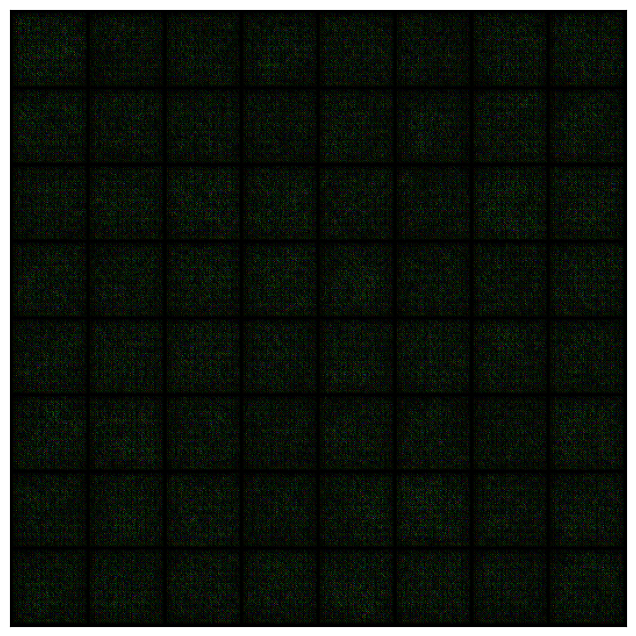

In [11]:
scales = [16, 32, 64, 128, 256]
learning_rate = 0.0002
epochs = 200

for generator_scale in scales:

  for discriminator_scale in scales:
    generator = (
      Generator(use_gpu=config.use_gpu, scale=generator_scale)
      .apply(initialize_weights)
      .to(device)
    )
    discriminator = (
      Discriminator(use_gpu=config.use_gpu, scale=discriminator_scale)
      .apply(initialize_weights)
      .to(device)
    )

    output_directory = f'results/{generator_scale}-{discriminator_scale}'
    model_directory = f'models/{generator_scale}-{discriminator_scale}'

    os.makedirs(output_directory, exist_ok=True)
    os.makedirs(model_directory, exist_ok=True)

    constant_noise = torch.randn(64, latent_size, 1, 1, device=device)
    save_samples(0, constant_noise)

    (
      losses_generator,
      losses_discriminator,
      images_scores,
      noises_scores,
      fid_scores
    ) = fit(
      discriminator,
      generator,
      dataloader,
      epochs=epochs,
      learning_rate=learning_rate
    )

    torch.save(generator.state_dict(), f'{model_directory}-generator.pt')
    torch.save(discriminator.state_dict(), f'{model_directory}-discriminator.pt')

    scores_directory = f'scores/{generator_scale}-{discriminator_scale}'
    os.makedirs(scores_directory, exist_ok=True)
    csv = open(f'{scores_directory}.csv', 'w')
    csv.write('loss_generator,loss_discriminator,images_score,noises_score,fid_score\n')
    for epoch in range(epochs):
      csv.write(
        f'{losses_generator[epoch]},{losses_discriminator[epoch]},{images_scores[epoch]},{noises_scores[epoch]},{fid_scores[epoch]}\n')
